# Forecast weekly gross for Gershwin Theatre using SARIMAX

For the non-exogenous parameters of the SARIMAX model, we use the values (2,1,2)x(0,1,1,52) that has been used for the SARIMA model. We choose 'avg_ticket_price' and 'possible_gross' as the exogenous variables.


## Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pmdarima as pm

from pathlib import Path
from pylab import rcParams
from itertools import product

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse # Root Mean Square Error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

## Notebook Settings

In [2]:
warnings.filterwarnings("ignore")  # hide warnings

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [18, 10]

## Useful Functions

In [3]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),index=test.index)
    ax = train.loc[start:].plot(style='-')
    test.plot(ax=ax, style='--')
    forecast.plot(ax=ax)
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.savefig('new_fig.png')
    plt.show()

## Get the Data

In [4]:
filepath = 'grosses.csv'
data = pd.read_csv(filepath,
                 header=0,
                 parse_dates=['week_ending'],
                 index_col=0,
                 usecols=['week_ending','theatre','weekly_gross'])
data_e = pd.read_csv(filepath,
                 header=0,
                 parse_dates=['week_ending'],
                 index_col=0,
                 usecols=['week_ending','theatre','weekly_gross','avg_ticket_price','potential_gross'])

In [5]:
gershwin_df = data[(data['theatre'] == 'Gershwin Theatre')]

In [6]:
gershwin_df_e = data_e[(data_e['theatre'] == 'Gershwin Theatre')]

In [7]:
gershwin_df.drop(['theatre'], axis=1, inplace = True) 

In [8]:
gershwin_df_e.drop(['theatre'], axis=1, inplace = True) 

In [9]:
### We will use data for Gershwin Theatre from 2013-06-02 to 2019-05-26.
start_date = '2013-06-02'
#end_date = '2018-05-27'
end_date = '2019-05-26'
gershwin_df = gershwin_df.loc[start_date : end_date]
gershwin_df = gershwin_df.asfreq('W')
gershwin_df.head(1)
gershwin_df_e = gershwin_df_e.loc[start_date : end_date]
gershwin_df_e = gershwin_df_e.asfreq('W')
gershwin_df_e.head(1)

,weekly_gross,potential_gross,avg_ticket_price
week_ending,,,
2013-06-02,1776282.0,1681127.0,127.36


In [10]:
gershwin_df_e[gershwin_df_e['weekly_gross'].isna()]

,weekly_gross,potential_gross,avg_ticket_price
week_ending,,,
2015-12-27,NaN,NaN,NaN


In [11]:
gershwin_df = gershwin_df.fillna(method='ffill')
gershwin_df_e = gershwin_df_e.fillna(method='ffill')

In [12]:
y = gershwin_df.weekly_gross[261:]

In [13]:
model = pm.arima.ARIMA(order=(2,1,2),seasonal_order=(0,1,1,52),with_intercept=False)

In [14]:
model.fit(gershwin_df.values[0:261],X = gershwin_df_e[['avg_ticket_price','potential_gross']][0:261])

ARIMA(order=(2, 1, 2), seasonal_order=(0, 1, 1, 52), with_intercept=False)

In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  261
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 52)   Log Likelihood               -2705.800
Date:                              Fri, 02 Jun 2023   AIC                           5427.599
Time:                                      21:09:37   BIC                           5454.299
Sample:                                  06-02-2013   HQIC                          5438.395
                                       - 05-27-2018                                         
Covariance Type:                                opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
avg_ticket_price  1.717e+04    748.787     22.931      0.000    1.57e+04    1.86e+04
potential_gross      0.5731      0.043     13.237      0.000       0.488       0.658
ar.L1                0.5506      0.375      1.467      0.142      -0.185       1.286
ar.L2               -0.3683      0.297     -1.239      0.215      -0.951       0.214
ma.L1               -0.6893      0.381     -1.810      0.070      -1.436       0.057
ma.L2                0.2450      0.346      0.708      0.479      -0.433       0.923
ma.S.L52            -0.4424      0.051     -8.609      0.000      -0.543      -0.342
sigma2             1.14e+10   3.52e-05   3.24e+14      0.000    1.14e+10    1.14e+10
===================================================================================
Ljung-Box (L1) (Q):                   3.45   Jarque-Bera (JB):                 5.22
Prob(Q):                              0.06   Prob(JB):                         0.07
Heteroskedasticity (H):               0.50   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.33e+30. Standard errors may be unstable.
"""

In [16]:
preds, conf_int = model.predict(n_periods=52, X=gershwin_df_e[['avg_ticket_price','potential_gross']][261:], return_conf_int=True)

In [17]:
rmse(y,preds)

79974.63659809661

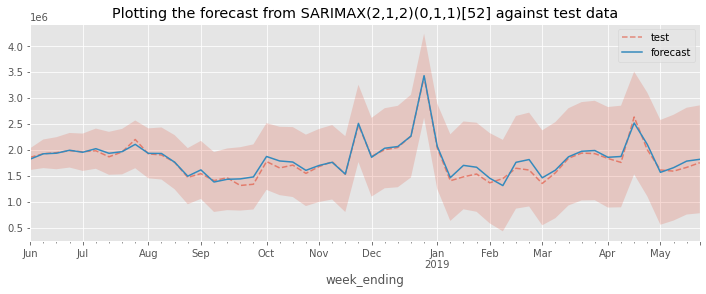

In [18]:
n = y.shape[0]
lower_ci, upper_ci  = zip(*conf_int)
index = y.index
ax = y.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(preds, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast'])
plt.title("Plotting the forecast from SARIMAX(2,1,2)(0,1,1)[52] against test data")
plt.savefig("with_external.png")
plt.show()